In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from xgboost import XGBClassifier
import shap

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

Dataframe shape: (11055, 31)
Number of 1: 6157
Number of -1: 4898


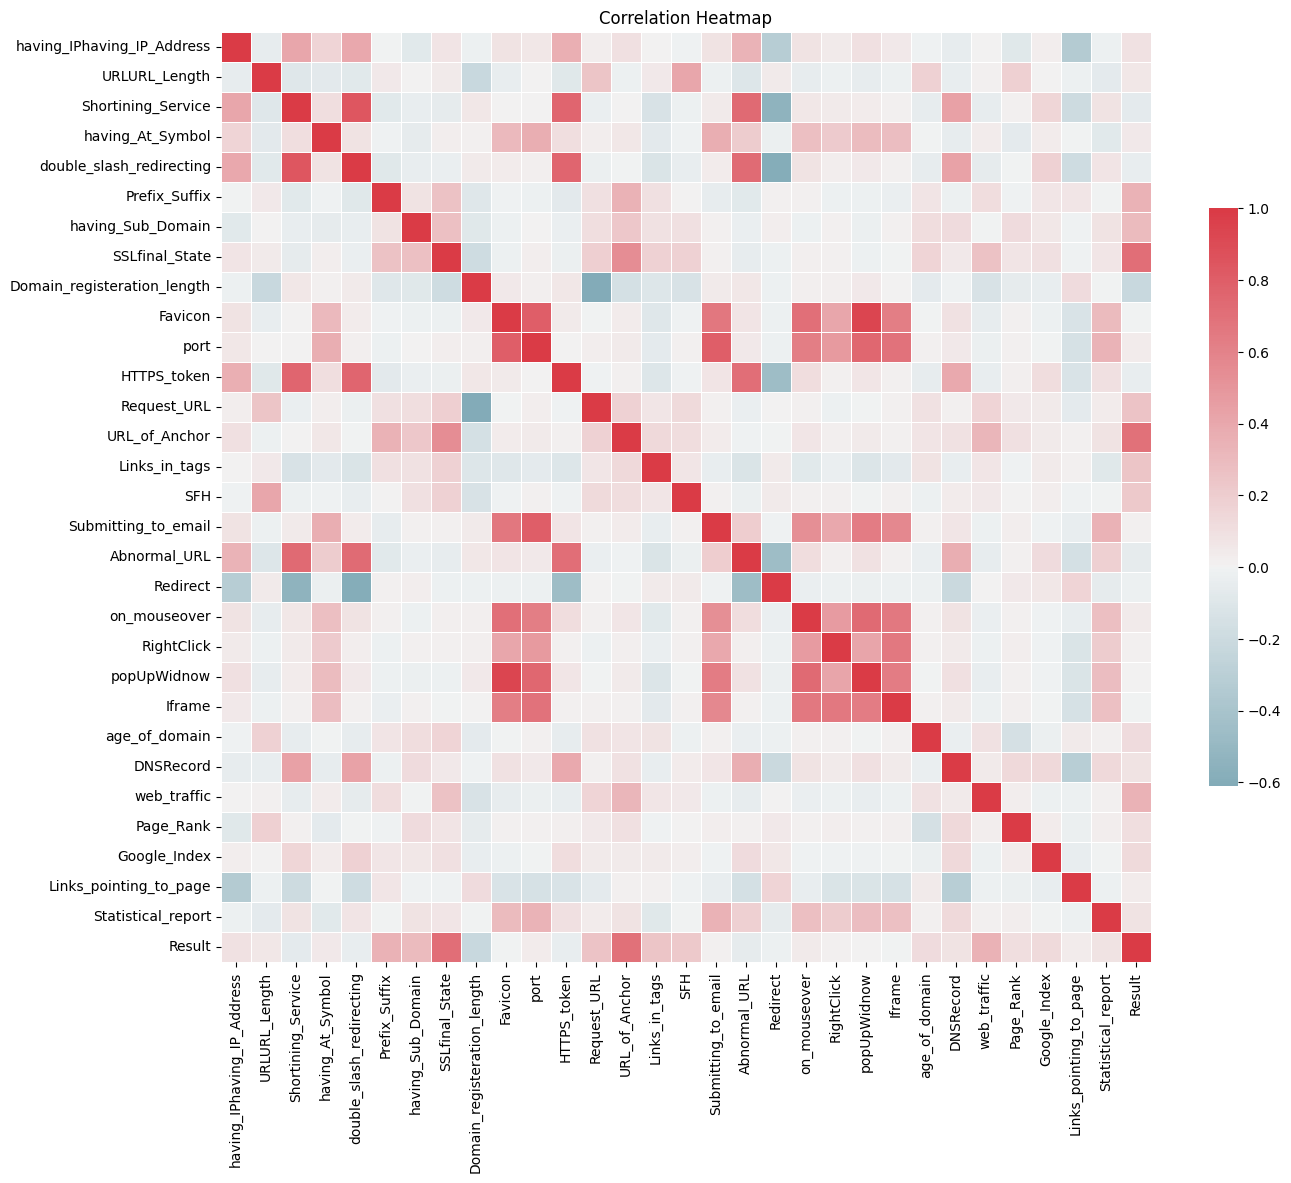

In [ ]:
df = pd.read_csv('/content/dataset.csv', index_col=0)

print(f"Dataframe shape: {df.shape}")

X = df.drop('Result', axis=1)
y = df['Result'].replace(-1, 0)

print("Number of 1:", len(df[df["Result"] == 1]))
print("Number of -1:", len(df[df["Result"] == -1]))

#correlation matrix
corr = df.corr()

#heatmap
plt.figure(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME', random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss"),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=42)
}


Random Forest Accuracy: 0.9670, F1-Score: 0.9712
AdaBoost Accuracy: 0.9299, F1-Score: 0.9386
XGBoost Accuracy: 0.9706, F1-Score: 0.9744
KNN Accuracy: 0.9408, F1-Score: 0.9481
SVM Accuracy: 0.9471, F1-Score: 0.9540


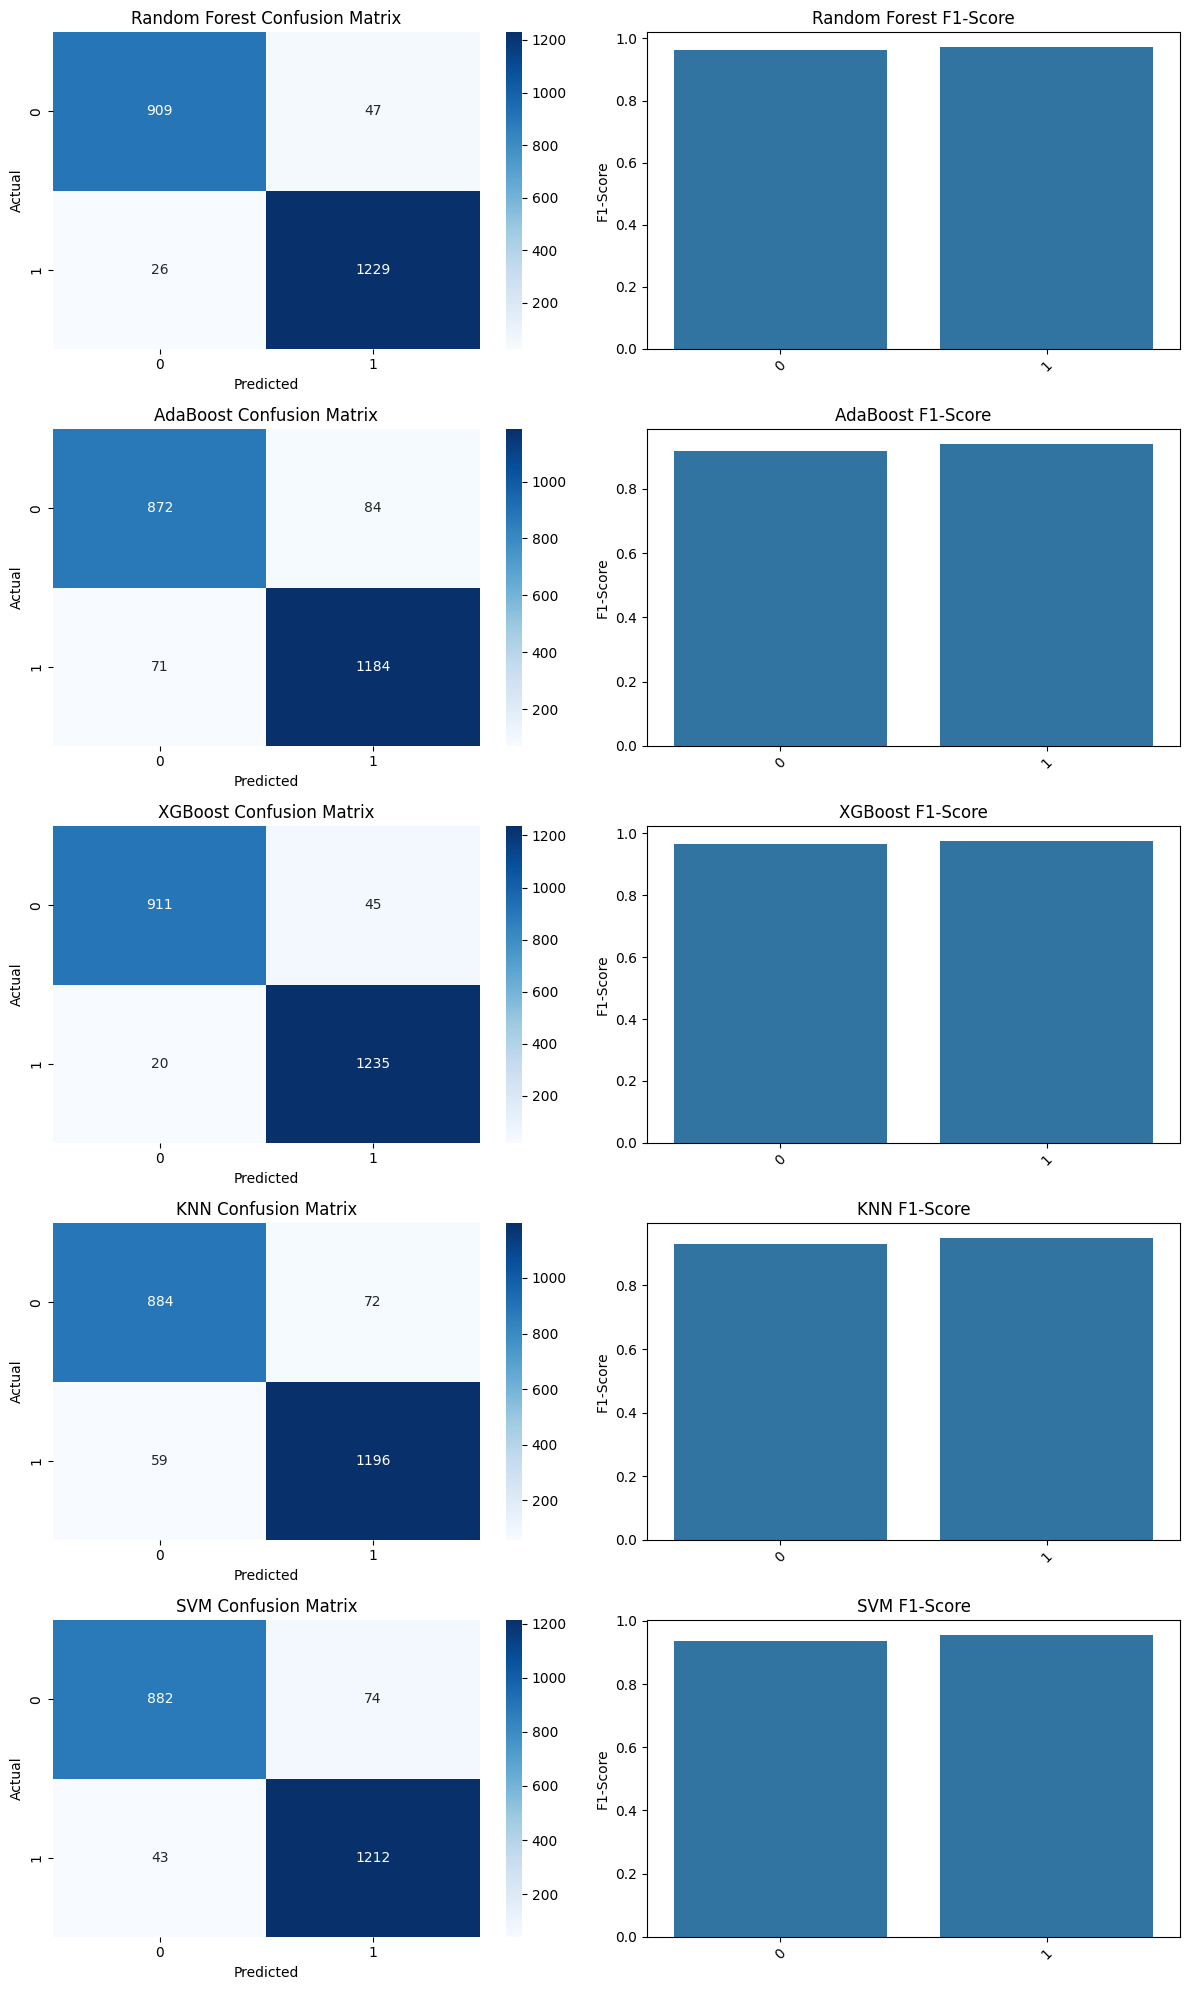

In [ ]:
fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(12, len(models) * 4))
axes = axes.flatten()

metrics_list = []

for i, (model_name, model) in enumerate(models.items()):
    #Fitting the model
    model.fit(X_train, y_train)

    #Making predictions
    y_pred = model.predict(X_test)

    #Calculating metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['1']['f1-score']  # Assuming '1' is the positive class

    metrics_list.append({"Model": model_name, "Accuracy": accuracy, "F1-Score": f1})
    print(f"{model_name} Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

    #Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i*2], cmap='Blues')
    axes[i*2].set_title(f'{model_name} Confusion Matrix')
    axes[i*2].set_xlabel('Predicted')
    axes[i*2].set_ylabel('Actual')

    #F1-score Plot
    class_labels = list(report.keys())[:-3]  # Converting dict_keys to list
    f1_scores = [report[label]['f1-score'] for label in class_labels]
    sns.barplot(x=class_labels, y=f1_scores, ax=axes[i*2+1])
    axes[i*2+1].set_title(f'{model_name} F1-Score')
    axes[i*2+1].set_ylabel('F1-Score')
    axes[i*2+1].set_xticks(range(len(class_labels)))
    axes[i*2+1].set_xticklabels(class_labels, rotation=45)

plt.tight_layout()
plt.show()


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7568 - loss: 0.4763 - val_accuracy: 0.9195 - val_loss: 0.2012
Epoch 2/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9091 - loss: 0.2251 - val_accuracy: 0.9276 - val_loss: 0.1746
Epoch 3/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9274 - loss: 0.1847 - val_accuracy: 0.9313 - val_loss: 0.1670
Epoch 4/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9275 - loss: 0.1761 - val_accuracy: 0.9380 - val_loss: 0.1631
Epoch 5/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9380 - loss: 0.1593 - val_accuracy: 0.9344 - val_loss: 0.1521
Epoch 6/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9368 - loss: 0.1592 - val_accuracy: 0.9408 - val_loss: 0.1493
Epoch 7/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9387 - loss: 0.1527 - val_accuracy: 0.9430 - val_loss: 0.1452
Epoch 8/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9417 - loss: 0.1410 - val_accuracy: 0.9398 - val_

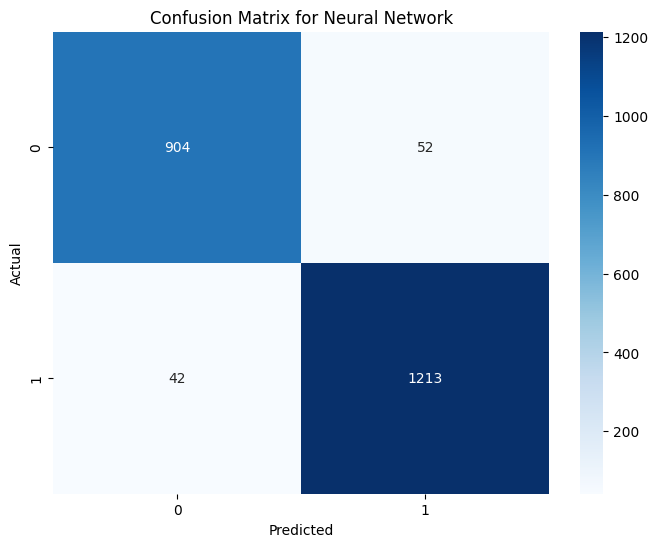

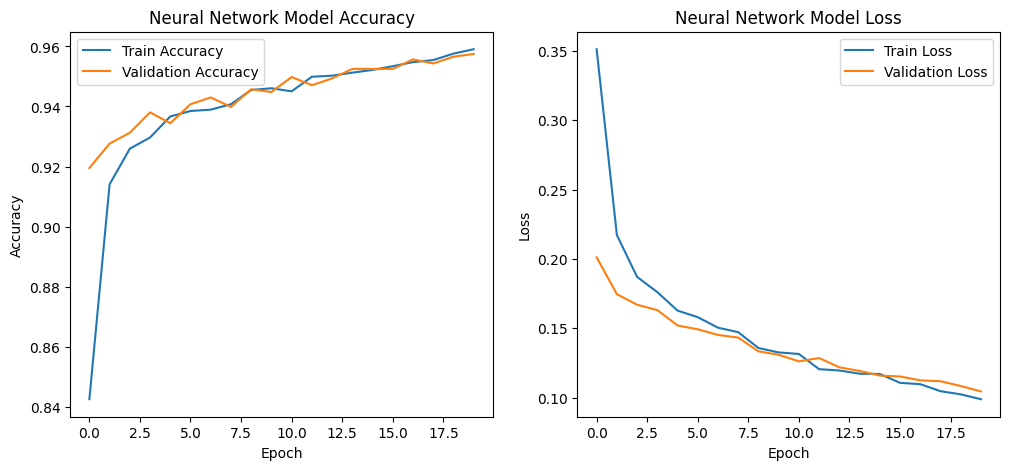

In [ ]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

#Define the neural network model
nn_model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])

#Compile neural network
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train neural network
history = nn_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=20, batch_size=32, verbose=1)

# Evaluate neural network
nn_loss, nn_accuracy = nn_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Neural Network Accuracy: {nn_accuracy:.4f}")

# Neural network predictions and metrics
y_pred_nn = np.argmax(nn_model.predict(X_test), axis=1)
nn_f1 = f1_score(y_test, y_pred_nn)
print(f"Neural Network F1-Score: {nn_f1:.4f}")

# Confusion Matrix for Neural Network
cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot training and validation accuracy and loss for the neural network
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

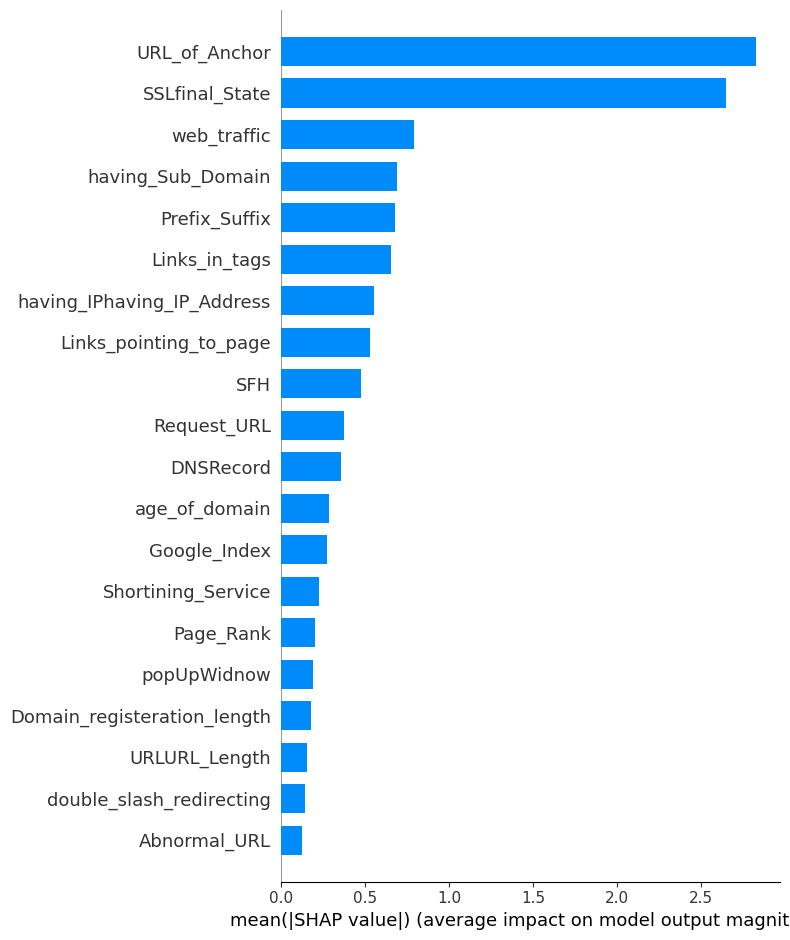

In [ ]:
explainer = shap.TreeExplainer(models["XGBoost"])
shap_values = explainer.shap_values(X_train)

#Display a SHAP summary plot
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type="bar")


In [ ]:
comparison_df = pd.DataFrame(metrics_list)
comparison_df = pd.concat([comparison_df, pd.DataFrame([{"Model": "Neural Network", "Accuracy": nn_accuracy, "F1-Score": nn_f1}])], ignore_index=True)
print("\nComparison of Model Metrics:")
print(comparison_df)



Comparison of Model Metrics:
            Model  Accuracy  F1-Score
0   Random Forest  0.966983  0.971158
1        AdaBoost  0.929896  0.938565
2         XGBoost  0.970602  0.974359
3             KNN  0.940751  0.948078
4             SVM  0.947083  0.953955
5  Neural Network  0.957485  0.962698


In [ ]:
from google.colab import drive
drive.mount('/content/drive')